# Numerical differentiation of noisy data: Ground truth results

This notebook builds based on `1_basic_tutorial.ipynb` by calling optimization routines to find optimal parameters for each method.

### Notations:
  * dt: (float) step size (note: the symbol "dt" comes from differentiating timeseries data, however these functions work for a 1-dimensional spatial derivative as well)
  * x: (np.array with length N) the data you want to differentiate
  * x_hat: (np.array with length N) the smoothed estimate of x
  * x_truth: (np.array with length N) the true value of x (which is known when the data is simulated, and used for plotting purposes only)
  * dxdt_hat: (np.array with length N) the estimate of the derivative of x
  * dxdt_truth: (np.array with length N) the true value of dxdt (which is known when the data is simulated, and used for plotting purposes only)

In [1]:
from pynumdiff.optimize import optimize
from pynumdiff.utils import evaluate
from pynumdiff.utils.simulate import sine, triangle, pop_dyn, linear_autonomous,\
	pi_cruise_control, lorenz_x
from pynumdiff.finite_difference import finitediff
from pynumdiff.smooth_finite_difference import kerneldiff, butterdiff
from pynumdiff.polynomial_fit import splinediff, polydiff, savgoldiff
from pynumdiff.basis_fit import spectraldiff, rbfdiff
from pynumdiff.total_variation_regularization import tvrdiff, smooth_acceleration
from pynumdiff.kalman_smooth import rtsdiff, robustdiff
from pynumdiff.linear_model import lineardiff

# 0. Simulate some data

pynumdiff comes with 6 different toy problems (choose the one that most resembles your data to see how the methods compare):
* lorenz_x: (nonlinear) x component of a lorenz attractor
* sine: (linear) sum of two sines
* pop_dyn: (nonlinear) bounded exponential growth
* triangle: (nonlinear) sharp-edged triangle wave with increasing frequency
* pi_cruise_control: (linear / nonlinear) linear proportional integral controller with nonlinear control inputs

In [2]:
noise_type = 'normal' # noise is generated using np.random, e.g. 'normal', 'uniform', 'poisson'
noise_parameters = [0, 0.1]  # compatible with np.random functions 

dt = 0.01 # step size and series length in terms of independent variable
duration = 4
problem = pi_cruise_control # select one of the options imported from the simulate module

x, x_truth, dxdt_truth = problem(duration, noise_type=noise_type,
                                noise_parameters=noise_parameters, dt=dt)

For our toy problems we can optimize the parameters in one of two options:
1. Use the known dxdt to find the best parameters 
2. Actual dxdt is unknown

In the real world, option (1) is not possible, but this notebook focuses on this case. For the second case, see notebook 2b.

Use the following syntax, as detailed in the notebook:

```python
from pynumdiff.optimize import optimize
from pynumdiff.module import method

search_space_updates = {'param1':[values], 'param2':[values], ...}

params, val = optimize(method, x, dt,
                    tvgamma=tvgamma, # hyperparameter
                    dxdt_truth=dxdt_truth, # defaults to None if no ground truth data
                    search_space_updates=search_space_updates)
					
x_hat, dxdt_hat = method(x, dt, **params)
```

where `param`s are keyword arguments that come from the method definition. If you don't know a search space, default search spaces are defined for all methods in `optimize.py`. Partial search spaces are accepted, simply replacing relevant entries in the default search space. Reasonable upper and lower bounds are defined for numerical search space dimensions (type `int` or `float`). Data type `bool` can also be searched over, but searching over `str` parameters is currently not supported.

Since we are optimizing on the actual values, there is no need to regularize, so `optimize`'s `tvgamma` parameter is ignored during optimization.

## 1. Smooth Finite Difference

### 1.1 Kernel smoothing

Optimal parameters:  {'window_size': 20, 'num_iterations': 1, 'kernel': 'gaussian'}
val = 0.6456841747296562 is the minimal 'rmse' by default but can also minimize 'error_correlation'


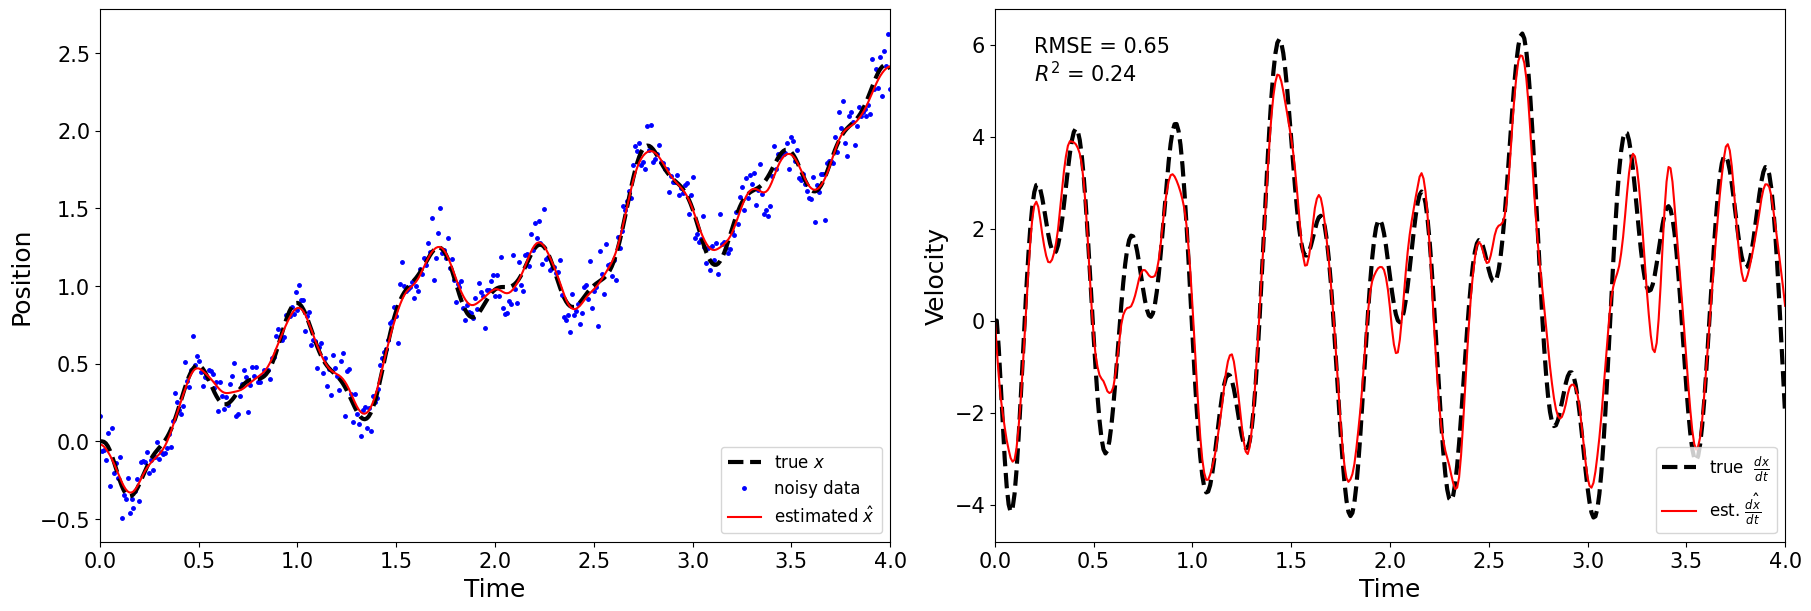

In [16]:
params, val = optimize(kerneldiff, x, dt, dxdt_truth=dxdt_truth, metric='rmse')
print('Optimal parameters: ', params)
print(f"val = {val} is the minimal 'rmse' by default but can also minimize 'error_correlation'")
x_hat, dxdt_hat = kerneldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 1.2 Butterworth smoothing

Optimal parameters:  {'cutoff_freq': np.float64(0.09484375), 'num_iterations': 1, 'filter_order': 4}


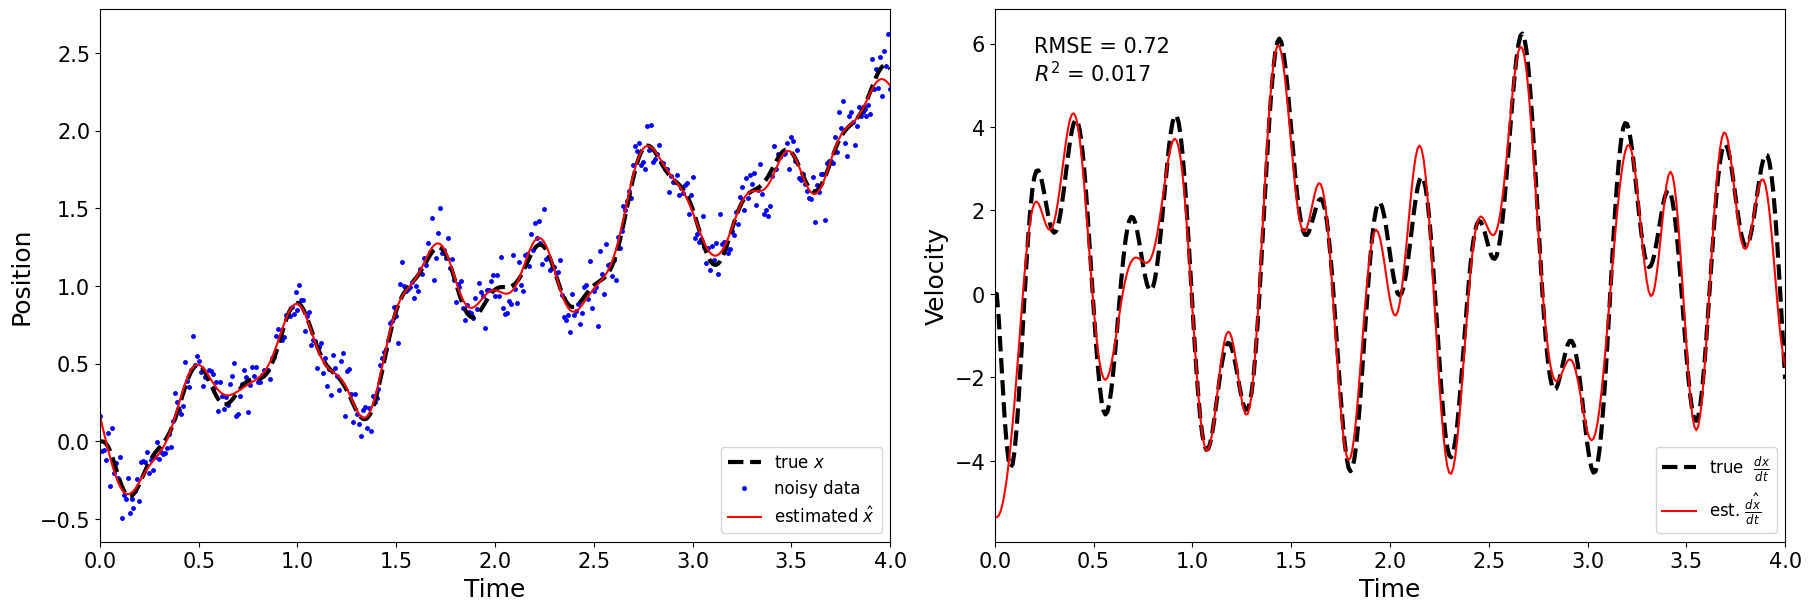

In [4]:
params, val = optimize(butterdiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = butterdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

## 2. Iterated Finite Difference

Optimal parameters:  {'num_iterations': 73, 'order': 4}


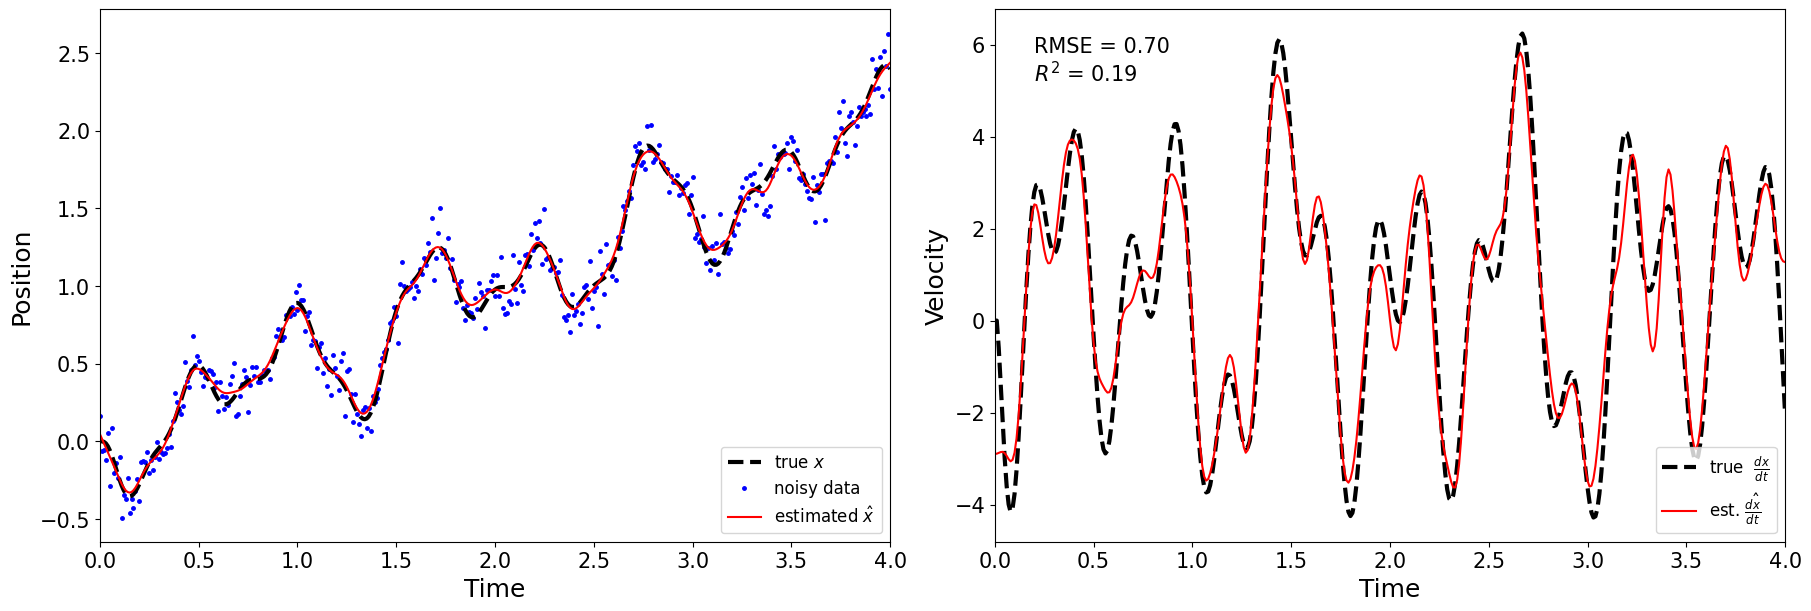

In [5]:
params, val = optimize(finitediff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = finitediff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

## 3. Polynomial-Based Methods

### 3.1 Sliding polynomial fit

Optimal parameters:  {'step_size': 1, 'degree': 3, 'window_size': 40, 'kernel': 'friedrichs'}


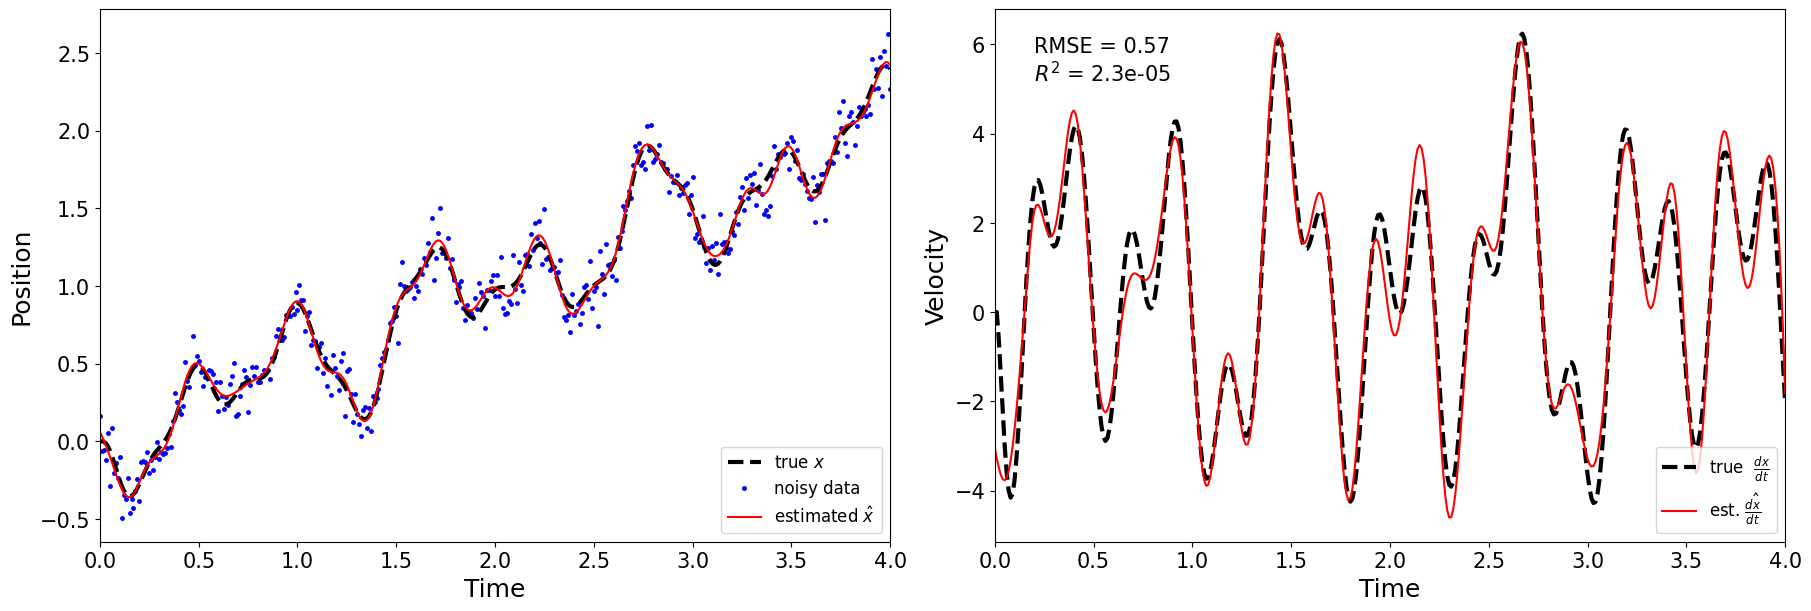

In [6]:
params, val = optimize(polydiff, x, dt, dxdt_truth=dxdt_truth, search_space_updates={'step_size':[1, 2, 5]})
print('Optimal parameters: ', params)
x_hat, dxdt_hat = polydiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 3.2 Savitzky-Golay filter

Optimal parameters:  {'degree': 5, 'window_size': 39, 'smoothing_win': 12}


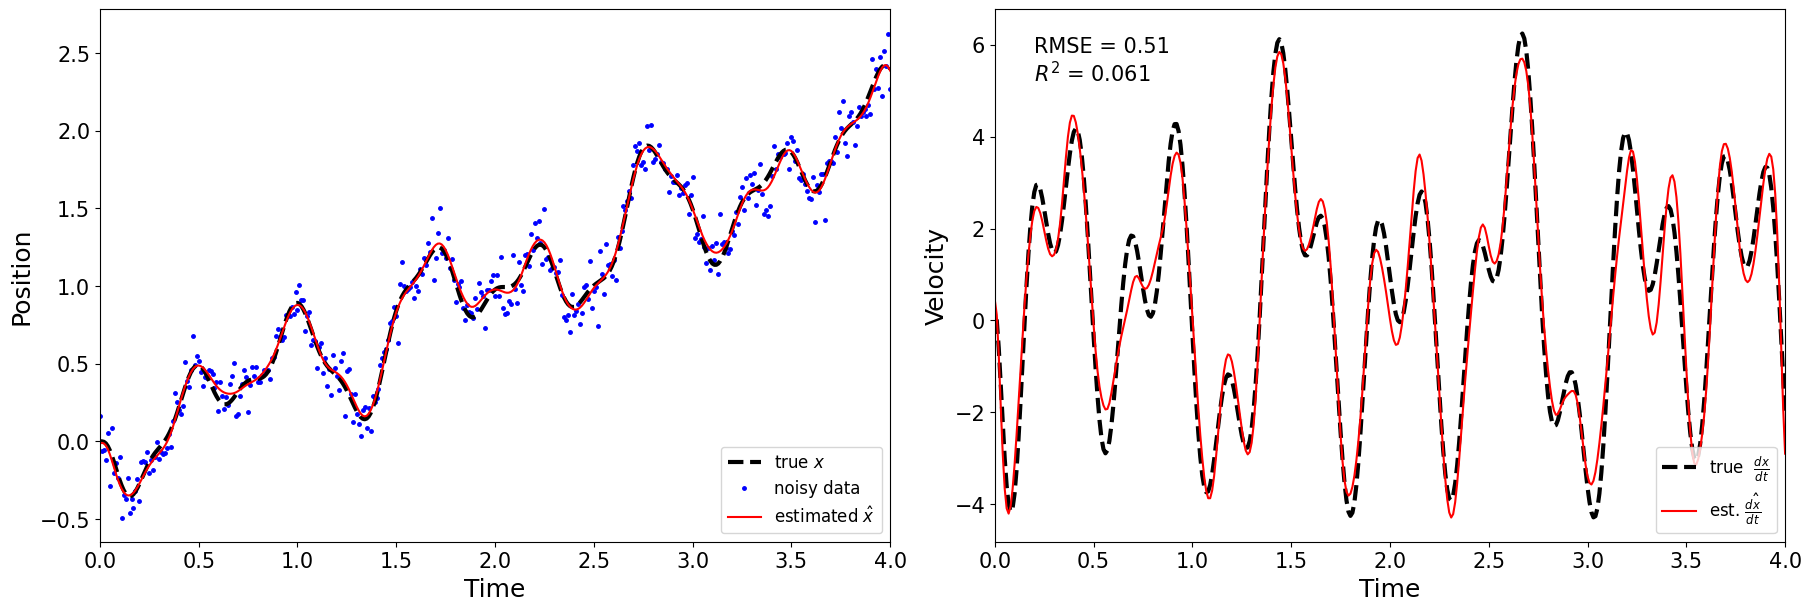

In [7]:
params, val = optimize(savgoldiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = savgoldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 3.3 Splines

Optimal parameters:  {'s': np.float64(0.5531249999999999), 'num_iterations': 5, 'degree': 3}


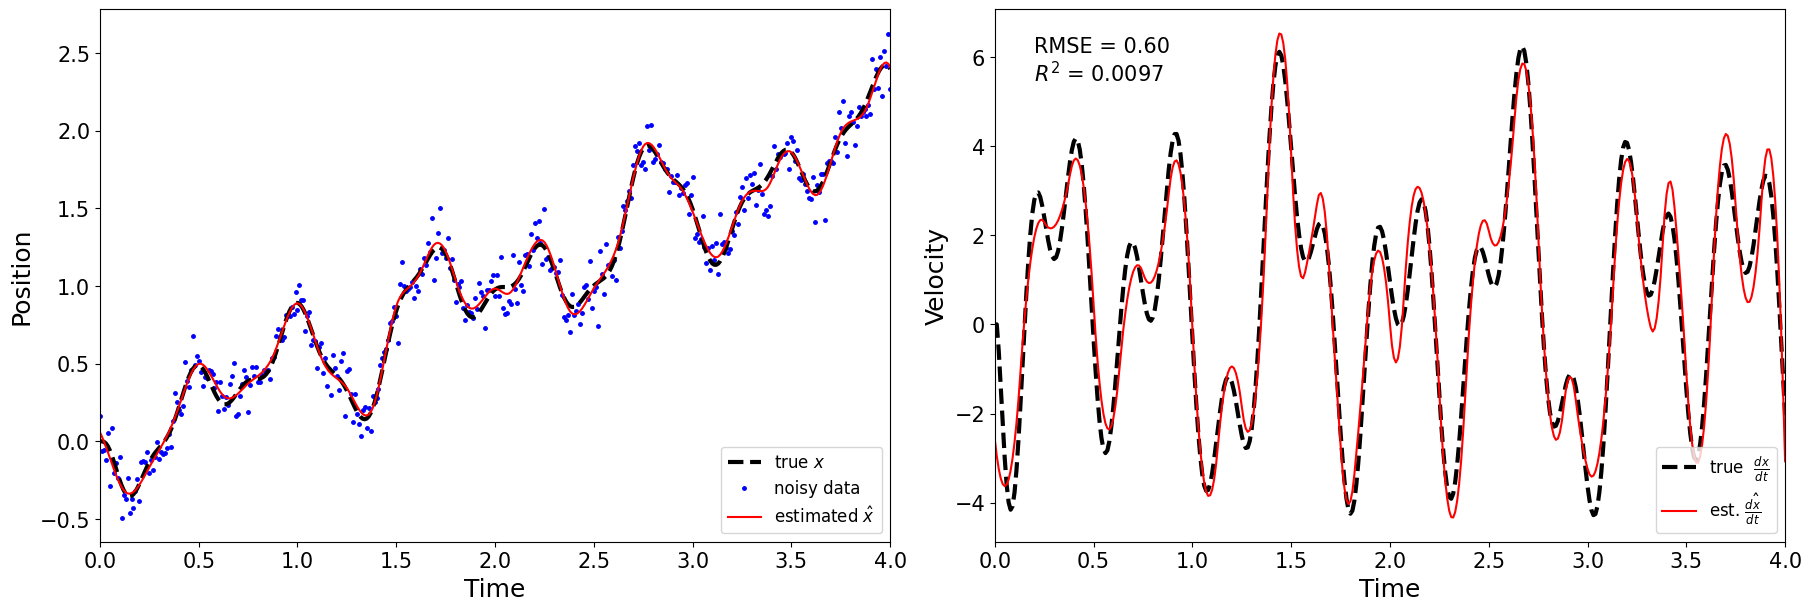

In [8]:
params, val = optimize(splinediff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = splinediff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

## 4. Basis-Function-Based Methods

### 4.1 Spectral Derivative with Tricks

Optimal parameters:  {'high_freq_cutoff': np.float64(0.08906250000000004), 'pad_to_zero_dxdt': True, 'even_extension': True}


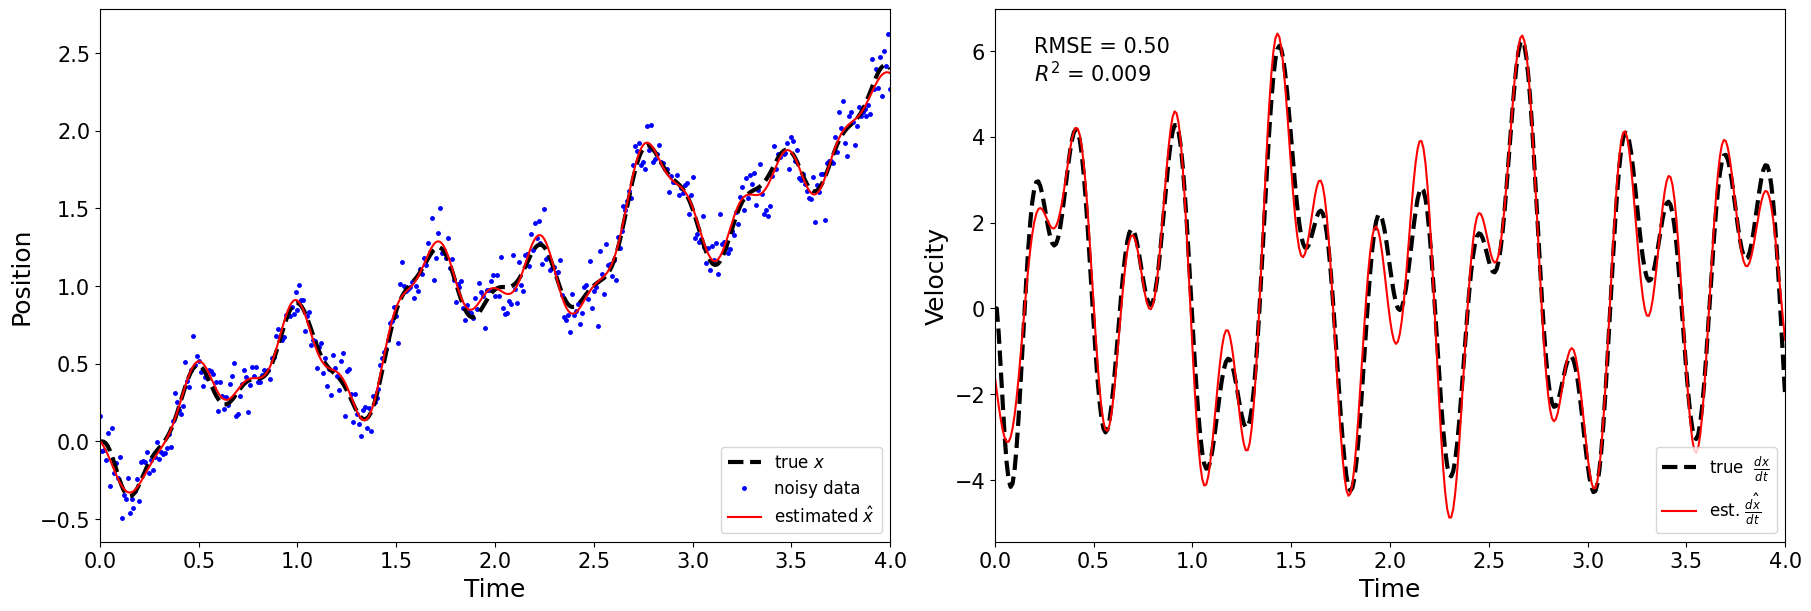

In [9]:
params, val = optimize(spectraldiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = spectraldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 4.2 Radial Basis Functions

Fit and differentiate a local basis.

Optimal parameters:  {'sigma': np.float64(0.11624999999999996), 'lmbd': np.float64(0.09499999999999995)}


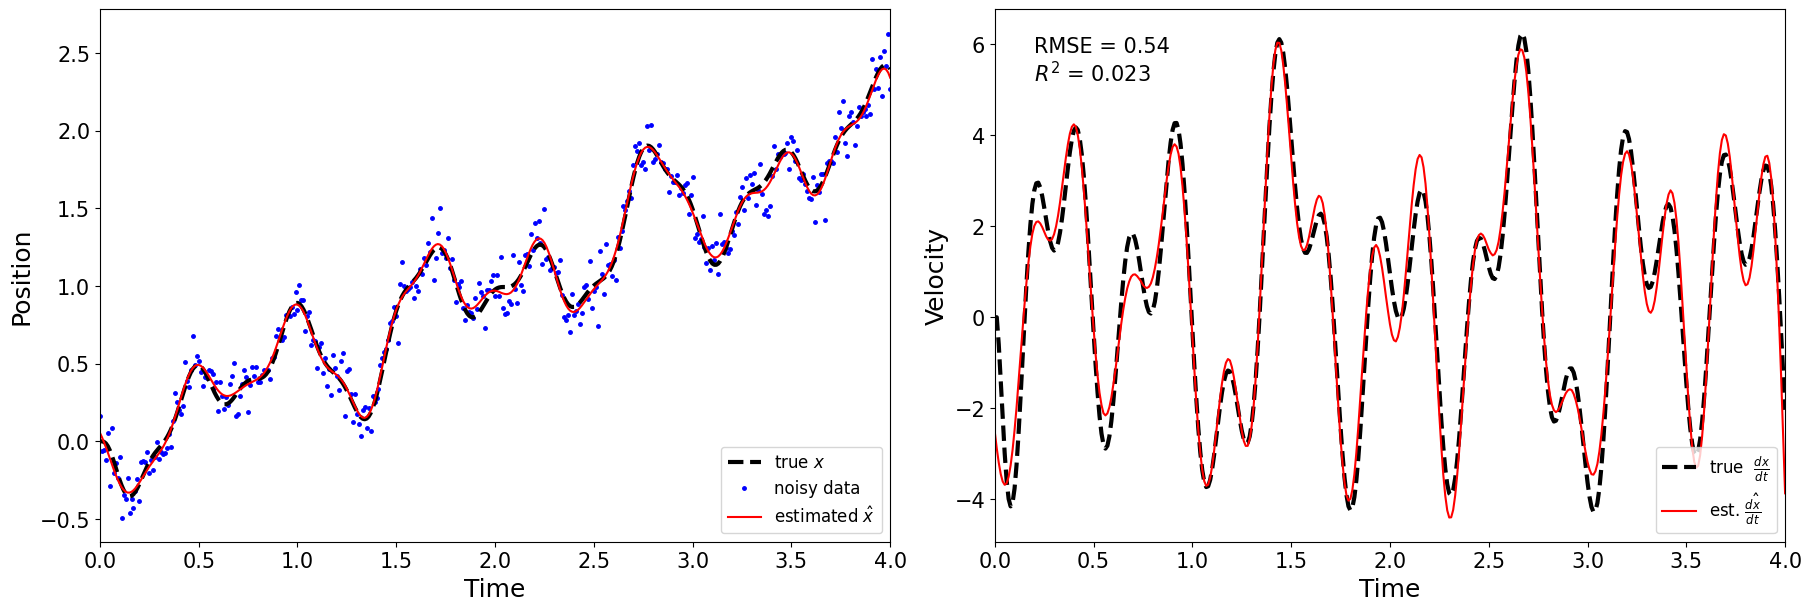

In [10]:
params, val = optimize(rbfdiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = rbfdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

## 5. Total Variation Regularization

### 5.1 Convex TVRed Derivative

Optimal parameters:  {'gamma': np.float64(12.46875), 'order': 3}


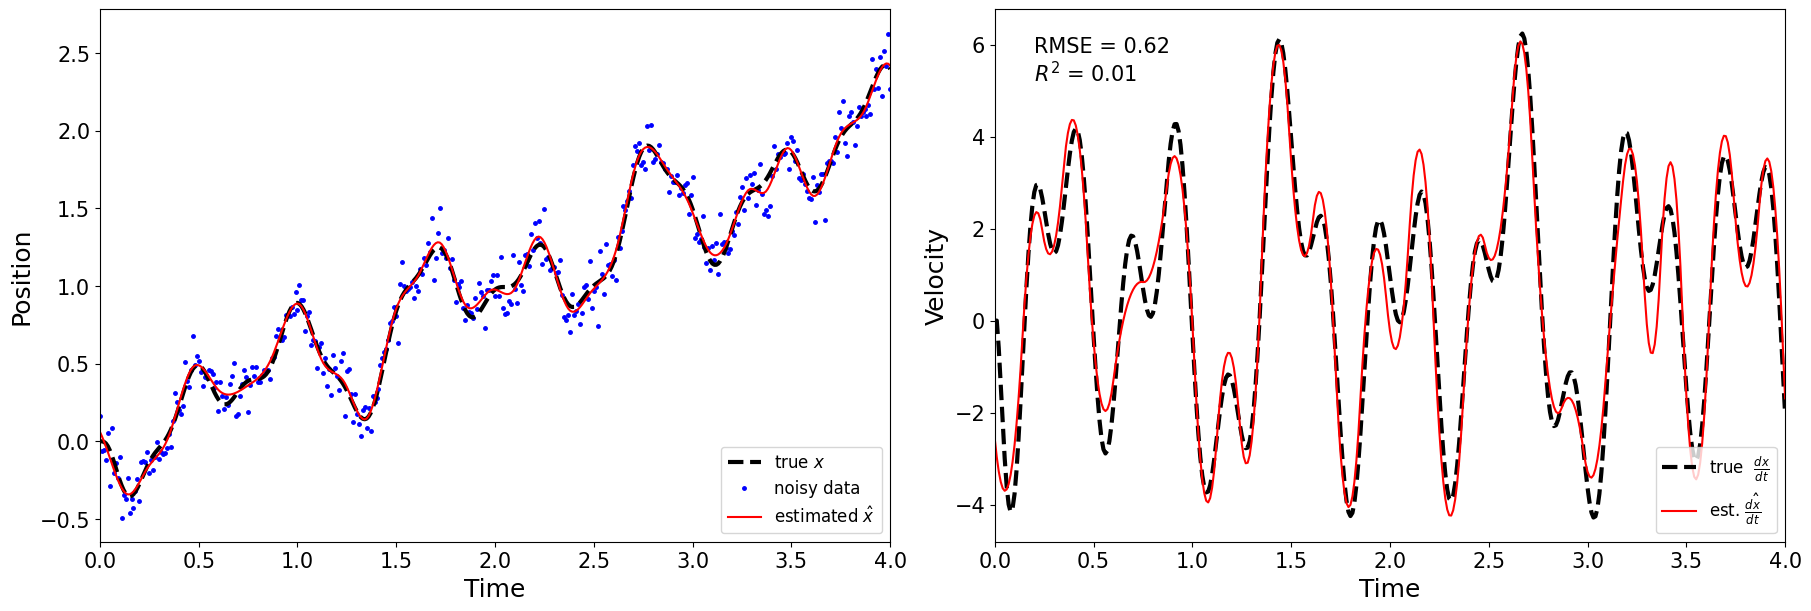

In [11]:
params, val = optimize(tvrdiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = tvrdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 5.2 TVR acceleration with gaussian smoothing

Optimal parameters:  {'gamma': np.float64(1.2152343749999992), 'window_size': 16}


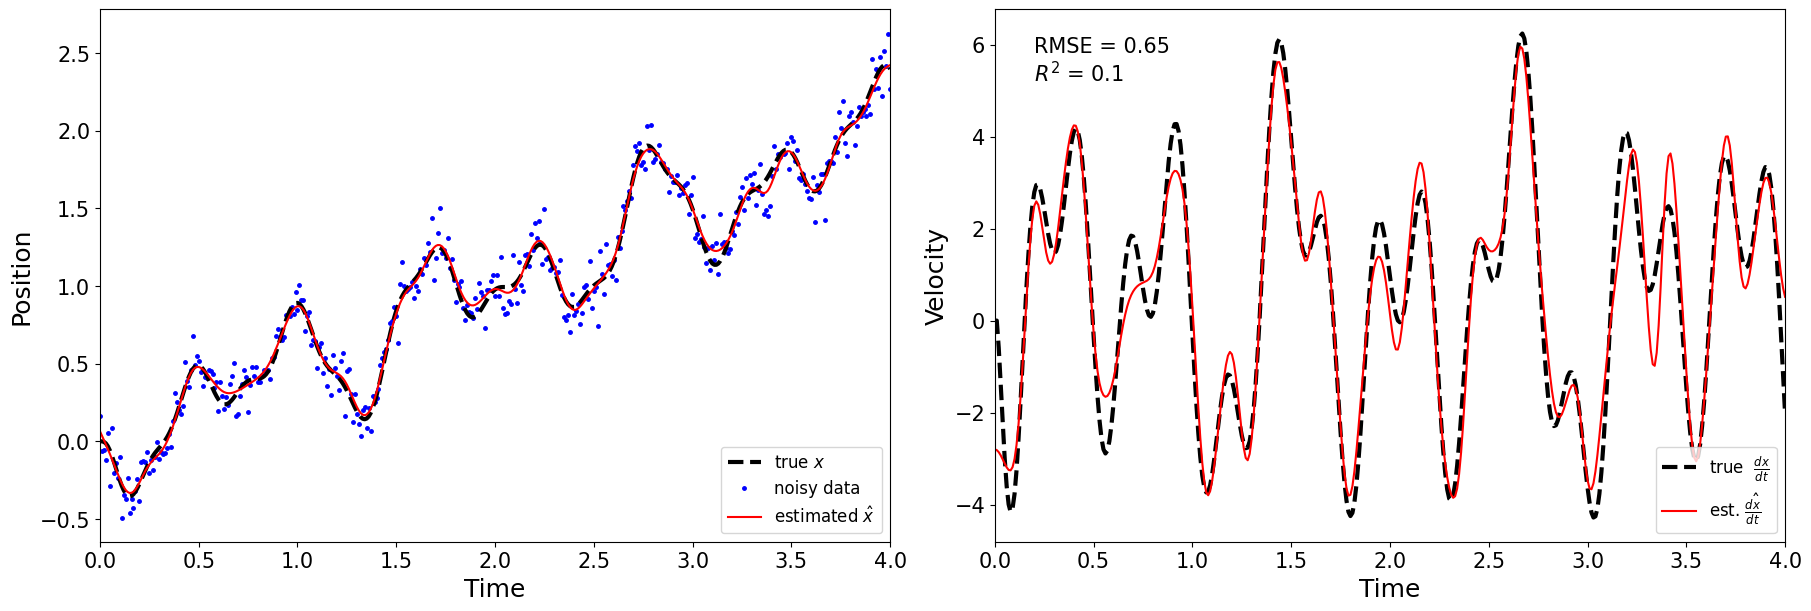

In [12]:
params, val = optimize(smooth_acceleration, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = smooth_acceleration(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

## 6. Kalman smoothing

### 6.1 RTS Smoothing

Optimal parameters:  {'qr_ratio': np.float64(7350000000.0), 'forwardbackward': True, 'order': 3}


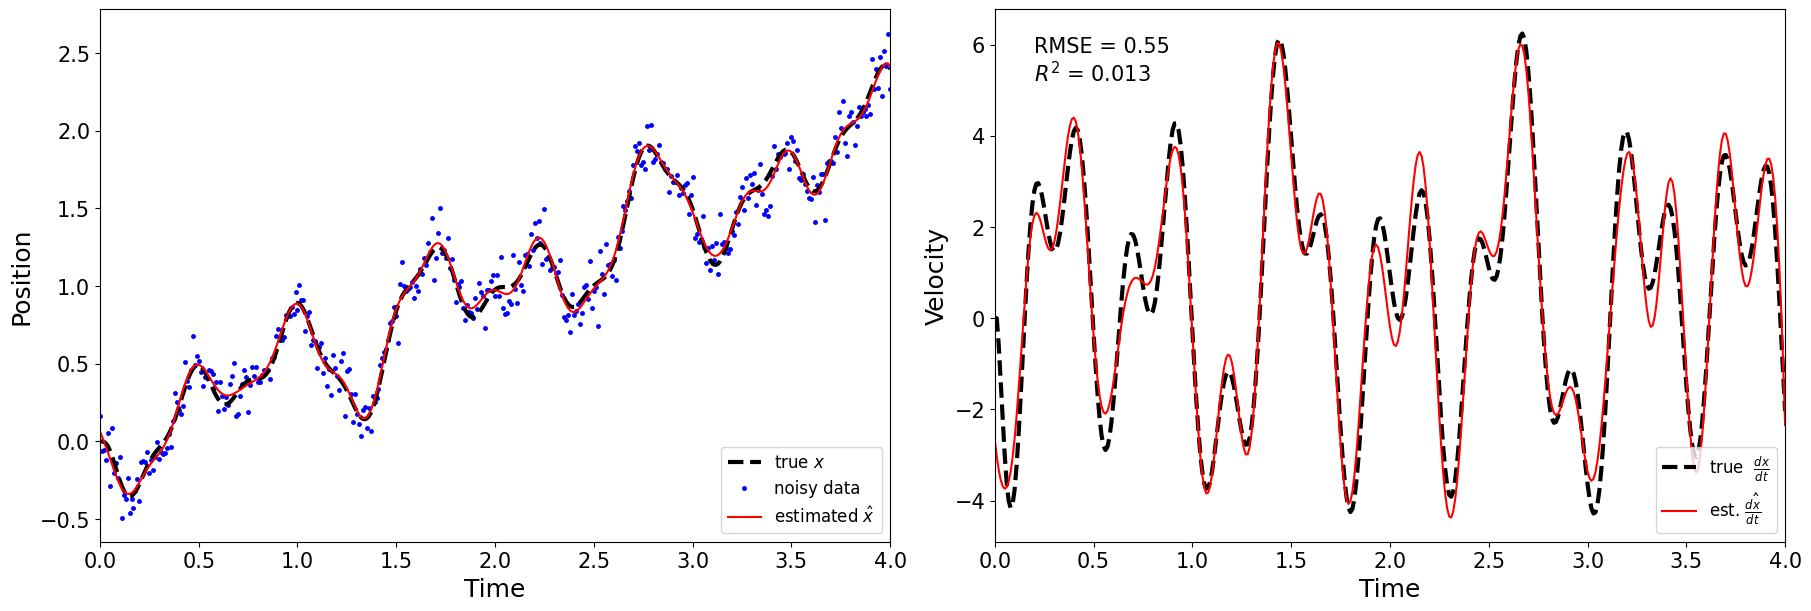

In [13]:
params, val = optimize(rtsdiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = rtsdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### Huber/$\ell_1$ Smoothing

The combination of 3-dimensional hyperparameter space and convex solver make this one significantly slower to optimize, about 10 minutes on my machine.

Optimal parameters:  {'qr_ratio': np.float64(41933593750.0), 'huberM': np.float64(32.3173828125), 'order': 3}


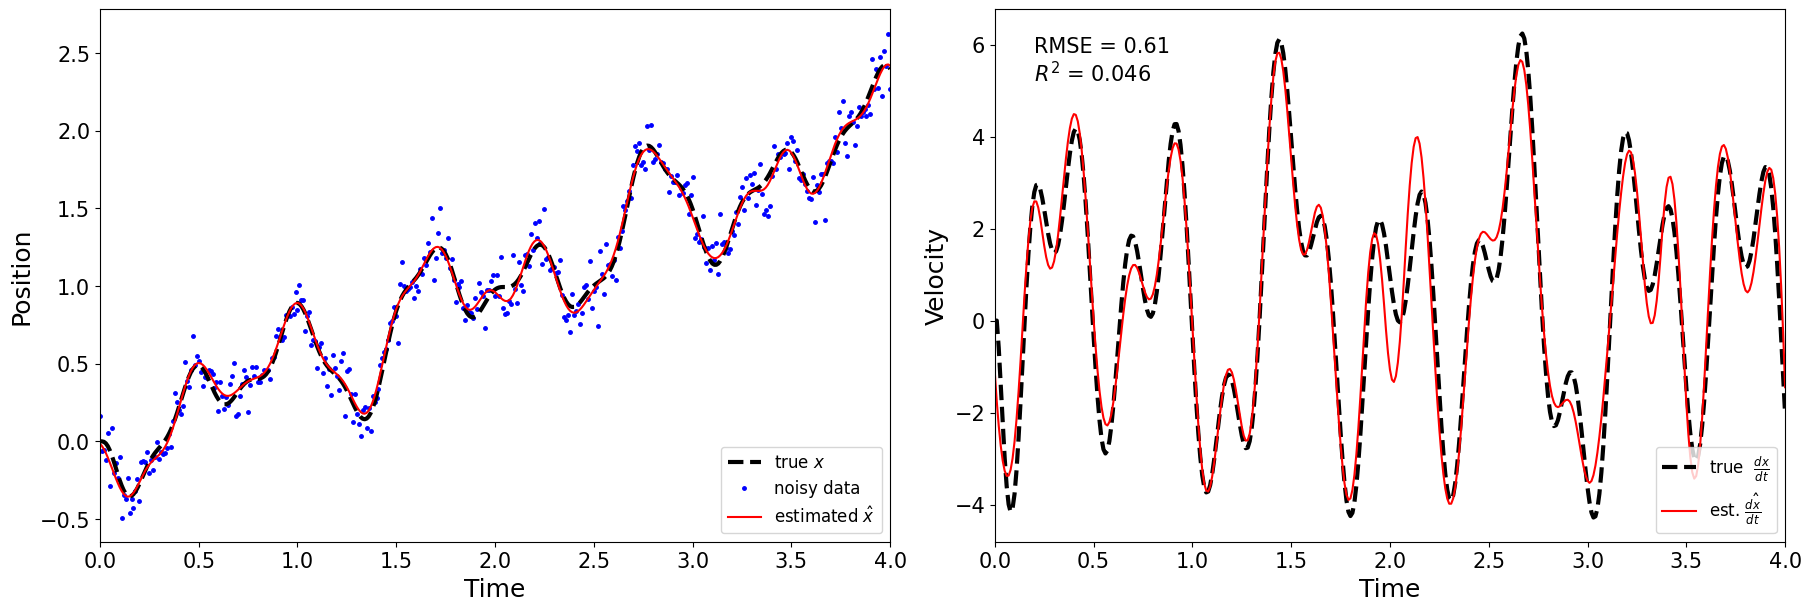

In [14]:
params, val = optimize(robustdiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = robustdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

## 7. Linear Model: Sliding linear time invariant system fit

In [15]:
if 0: # this one is too slow and runtime error prone!
    params, val = optimize(lineardiff, x, dt, dxdt_truth=dxdt_truth)
    print('Optimal parameters: ', params)
    x_hat, dxdt_hat = lineardiff(x, dt, **params)
    evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);